In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


In [183]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class ELM:
    def __init__(self, input_size, hidden_size = 10, output_size = 1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.w = np.random.randn(hidden_size, input_size)
        self.beta = np.random.randn(output_size, hidden_size)        
        
    def update(self, x_new, y_new):
        x_new = np.array(x_new)
        y_new = np.array(y_new)
        
        y,h = self.forward(x_new)

        h_pinv = np.linalg.pinv(h)
        
        beta_est = y_new.dot(h_pinv)
        
        self.beta = beta_est
        
        return y, beta_est
        
        
    def forward(self, x):
        x = np.array(x)
        h = sigmoid(self.w.dot(x))

        y = self.beta.dot(h)
        
        return y, h
        
        

In [33]:
N = 100
t = np.linspace(-2.5,2.5,N)
xs = np.vstack([np.sin(0.1*t),np.sin(0.5*t),np.sin(2*t),np.sin(0.001*t)])

ys = np.expand_dims(t**5+0.1*t**2+0.3*t**3, axis = 0)

elm = ELM(4)

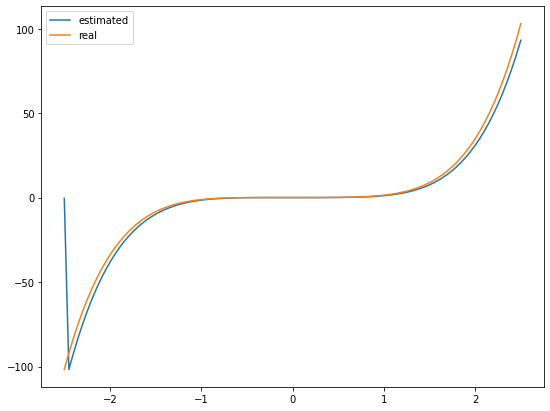

In [34]:
y_reals = []
y_ests = []

for i in range(N):
    x = xs[:,i:i+1]
    y_real = ys[:,i:i+1]
    
    y_est, _ = elm.update(x, y_real)
    
    y_reals.append(y_real)
    y_ests.append(y_est)
    
yrs = np.array(y_reals).squeeze()
yes = np.array(y_ests).squeeze()

f,ax = plt.subplots(1,1, figsize = (9,7))

ax.plot(t, yes)
ax.plot(t, yrs)
ax.legend(['estimated','real'])
    

In [184]:
I = 5 #input_size
K = 100 # hidden_size
L = 1 # output_size

B = 3  # Basis function

N0 = int(1.8*K*B)
M = 1000

def system_update(t = None):
    if not t:
        t = np.random.uniform(-2.5, 2.5)
    #t = np.linspace(-2.5,2.5,M+N0)
    x = np.vstack([1, np.sin(0.1*t),np.sin(0.5*t),np.sin(5*t),np.sin(t)])
    
    y = np.expand_dims(0.3*np.sin(4*t)-0.2*t**2-2, axis = 0) # t**5+0.1*t**2+0.3*t**3
    s = t
    return x, y, s



# Random Generate weight and select basis

w_b_ik = 1*np.random.randn(B,I,K)

def basis(n, b, dT = 0.05):
    n = n*dT
    if b == 0:
        f = 1
    elif b == 1:
        f = 1 # - 2*n / B
    elif b == 2:
        f = 1 #- 6*n / B  + 6 * n * (n-1) / B / (B-1) # n**2/2#2*n**2 - 1 # 0.5*(3*n**2-1)
    else:
        raise Exception('b is higher than expected')
    return f

# Accumulate N0 samples of training data
#N0 = int(1.8*K*B)

samples_x = []
samples_t = []
samples_s = []

for n in range(N0):
    x, t, s = system_update()
    samples_x.append(x)
    samples_t.append(t)
    samples_s.append(s)

samples_x = np.array(samples_x)
samples_t = np.array(samples_t)
    
# Calculate the time invariant hidden layer
G0 = []


for n in range(N0):
    
    h = []
    for k in range(K):
        g = []
        for i in range(I):
            w_ik = 0
            for b in range(B):
                w_ik += basis(n, b)* w_b_ik[b,i,k]
            g.append(samples_x[n,i]* w_ik)    
        g = np.sum(g) #np.minimum(0, np.sum(g))# np.tanh(np.sum(g)) #sigmoid(np.sum(g))# 
        h.append(g) 

    h = np.array(h)#np.expand_dims(np.array(h), axis=0)
    
    f = []
    for b in range(B):
        f.append(basis(n,b))

    f = np.array(f)#np.expand_dims(np.array(f), axis=0)
    G0.append(np.kron(h,f))
    
    
G0 = np.array(G0)
    
# Calculate P0 and T0
P0 = np.linalg.pinv(np.matmul(G0.T, G0)) # G0.T.dot(G0)

T0 = samples_t

# Calculate initial weight matrix
Omega0 = np.matmul(P0, np.matmul(G0.T, T0)) # P0.dot(G0.T.dot(T0))

Pm = P0
Omegam = Omega0

#print(Pm.shape) # 150x150 : KBxKB
#print(Omegam.shape) # 150x1 : KBxL

xs = []
ys = []
ts = []
ss = []
os = []

tlns = np.linspace(-2.5,2.5,M)

pbar = tqdm(total=M)
for m in range(M):
    pbar.update(n=1)
    x, t, s = system_update()#tlns[m])
    
    # Calculate g_m
    h = []
    for k in range(K):
        g = []
        for i in range(I):
            w_ik = 0
            for b in range(B):
                w_ik += basis(m+N0, b)* w_b_ik[b,i,k]
            g.append(x* w_ik)    
        g = np.sum(g) #np.minimum(0, np.sum(g))#np.tanh(np.sum(g))#sigmoid(np.sum(g))# np.tanh(np.sum(g))
        h.append(g) 

    h = np.array(h)#np.expand_dims(np.array(h), axis=0)

    f = []
    for b in range(B):
        f.append(basis(m+N0,b))

    f = np.array(f)#np.expand_dims(np.array(f), axis=0)
    
    g = np.kron(h,f)
    g = np.expand_dims(g, axis = 1)
    #print(g.T.shape)
    #print(Pm.shape)
    y = np.matmul(g.T,Omegam)
    
    Pm = Pm - np.matmul(Pm, np.matmul(g, np.matmul(g.T, Pm))) / (1 + (np.matmul(g.T, np.matmul(Pm,g))))    # Pm*g.dot(g.T)*(Pm)/(1 + (g.T*Pm).dot(g))
        
    Omegam = Omegam + np.matmul( Pm, np.matmul(g, t - np.matmul(g.T, Omegam))) #*g.dot(t-g.T.dot(Omegam))
    
    os.append(np.linalg.norm(Omegam))
    
    #print(g.T.shape)
    #rint(Omegam.shape)
    #print(y.shape)
    
    if m>0:#.7*M:
        xs.append(x)
        ys.append(np.squeeze(y))
        ts.append(t)
        ss.append(s)
pbar.close()



100%|██████████| 1000/1000 [00:23<00:00, 42.59it/s]


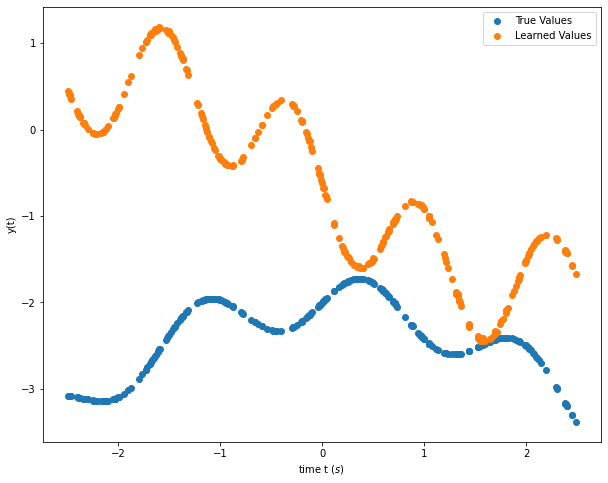

In [185]:
plt.figure(figsize = (10,8))

bottom = int(0.7*M)

plt.scatter(ss[bottom:-1], ts[bottom:-1])
    
plt.scatter(ss[bottom:-1], ys[bottom:-1])

plt.xlabel('time t ($s$)')
plt.ylabel('y(t)')


plt.legend(['True Values','Learned Values'])

#plt.ylim([-4, 0])

In [182]:
np.matmul(G0.T, G0)

array([[1897.30699882, 1897.30699882, 1897.30699882, ..., -861.1605345 ,
        -861.1605345 , -861.1605345 ],
       [1897.30699882, 1897.30699882, 1897.30699882, ..., -861.1605345 ,
        -861.1605345 , -861.1605345 ],
       [1897.30699882, 1897.30699882, 1897.30699882, ..., -861.1605345 ,
        -861.1605345 , -861.1605345 ],
       ...,
       [-861.1605345 , -861.1605345 , -861.1605345 , ..., 5748.46044559,
        5748.46044559, 5748.46044559],
       [-861.1605345 , -861.1605345 , -861.1605345 , ..., 5748.46044559,
        5748.46044559, 5748.46044559],
       [-861.1605345 , -861.1605345 , -861.1605345 , ..., 5748.46044559,
        5748.46044559, 5748.46044559]])

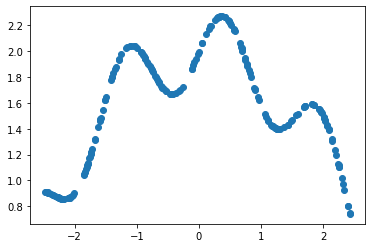

In [131]:
plt.scatter(samples_s, samples_t)

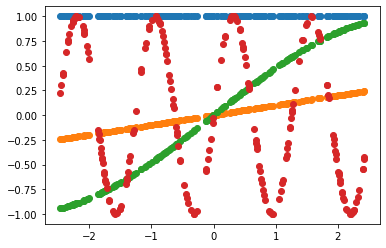

In [132]:
plt.scatter(samples_s, samples_x[:,0])
plt.scatter(samples_s, samples_x[:,1])
plt.scatter(samples_s, samples_x[:,2])
plt.scatter(samples_s, samples_x[:,3])

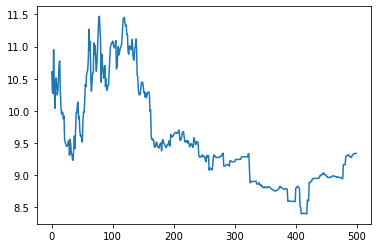

In [111]:
plt.plot(os)

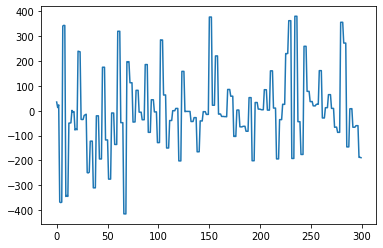

In [146]:
plt.plot(Omegam)